In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc as pm

sns.set()

limit = 100

In [2]:
def strip(x):
    return x.replace('\t','')

country_populations = pd.read_csv('world_pop.csv',
                                  sep=';',header=None,index_col=0,names=['population'],
                                 thousands=',',converters={0 : strip})


In [3]:
dick = pd.read_pickle('country_data.pkl')

us_state_dict = pd.read_pickle('us_state_dict.pkl')
ny = us_state_dict['New York']
ny.index = pd.DatetimeIndex(ny.index)
dick['New York'] = ny

ny.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44 entries, 2020-03-14 to 2020-04-26
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   confirmed    44 non-null     float64
 1   deceased     44 non-null     float64
 2   inc          44 non-null     float64
 3   dead_inc     44 non-null     float64
 4   factor       44 non-null     float64
 5   dead_factor  43 non-null     float64
 6   density      44 non-null     float64
 7   gdp          44 non-null     int64  
dtypes: float64(7), int64(1)
memory usage: 3.1 KB


In [4]:
def process_country(country_name):
    df = dick[country_name]
    
    df = df[df['confirmed'] > limit]
    
    resample_period = ['W-MON','W-TUE','W-WED','W-THU','W-FRI','W-SAT','W-SUN']
    
    today = pd.datetime.today().weekday()

    yesterday = lambda i : resample_period[i % 7 -1] if i != 0 else resample_period[6]
    print (today)
    print (yesterday(today))
    
    #### MAKE SURE to adjust the param of resample so that all data points for the last week are included
    weekly = df[['inc','dead_inc']].resample(yesterday(today)).sum()
    weekly[['inc_per_M','dead_inc_per_M']] = weekly[['inc','dead_inc']] / (
        country_populations.loc[country_name,'population'] / 1e6)
    ####
    
    weekly['factor'] = weekly['inc'] / weekly['inc'].shift()
    weekly['dead_factor'] = weekly['dead_inc'] / weekly['dead_inc'].shift()
    
    print ('+++++++ {} +++++++'.format(country_name))
    print (weekly)
    
    return weekly
    

In [5]:
def plot(weekly,country_name):
    
    plt.figure(figsize=(18,12))
    
    plt.plot(weekly.index,weekly['inc'],'x--',color='orange',
            label=r'new confirmed')
    plt.plot(weekly.index,weekly['dead_inc'],'x--',color='crimson',
            label = 'new dead')
    
   
    
    plt.plot(weekly.index,weekly['factor'],'o-',color='orange',
            label=r'weekly growth factor confirmed [ last weekly growth factor: {:.2f} ]'.format(weekly['factor'][-1]))
    
    plt.plot(weekly.index,weekly['dead_factor'],'o-',color='crimson',
             label=r'weekly growth factor dead [ last weekly growth factor: {:.2f} ]'.format(weekly['dead_factor'][-1]))
    
    plt.title('Corona - weekly sum of new CONFIRMED and DEAD for {} [confirmed > {}]'.format(str.upper(country_name),limit))
    
    plt.plot(weekly.index, [1] * len(weekly.index),color='lime',ls = 'dashed',label='factor 1.00')
    
    y_max = weekly['inc'].max() * 10
    y_min = 0.1
    
    plt.ylim([y_min,y_max])
    plt.yscale('log')
    plt.ylabel('weekly total')  
    plt.xticks(rotation=90)
    plt.legend(loc='upper left')
    
    plt.savefig('corona_weekly_sums_{}.jpg'.format(country_name),format='jpg')


0
W-SUN


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


+++++++ New York +++++++
                inc  dead_inc    inc_per_M  dead_inc_per_M     factor  \
2020-03-15    311.0       3.0    15.989717        0.154242        NaN   
2020-03-22  15068.0     114.0   774.704370        5.861183  48.450161   
2020-03-29  43848.0     848.0  2254.395887       43.598972   2.910008   
2020-04-05  63512.0    3194.0  3265.398458      164.215938   1.448458   
2020-04-12  65873.0    5226.0  3386.786632      268.688946   1.037174   
2020-04-19  58782.0    8913.0  3022.210797      458.251928   0.892353   
2020-04-26  40230.0    3971.0  2068.380463      204.164524   0.684393   

            dead_factor  
2020-03-15          NaN  
2020-03-22    38.000000  
2020-03-29     7.438596  
2020-04-05     3.766509  
2020-04-12     1.636193  
2020-04-19     1.705511  
2020-04-26     0.445529  
++++++++++++++++ NEW YORK ++++++++++++++
New York                 inc  dead_inc    inc_per_M  dead_inc_per_M     factor  \
2020-03-15    311.0       3.0    15.989717        0.154242 

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


0
W-SUN
+++++++ New York +++++++
                inc  dead_inc    inc_per_M  dead_inc_per_M     factor  \
2020-03-15    311.0       3.0    15.989717        0.154242        NaN   
2020-03-22  15068.0     114.0   774.704370        5.861183  48.450161   
2020-03-29  43848.0     848.0  2254.395887       43.598972   2.910008   
2020-04-05  63512.0    3194.0  3265.398458      164.215938   1.448458   
2020-04-12  65873.0    5226.0  3386.786632      268.688946   1.037174   
2020-04-19  58782.0    8913.0  3022.210797      458.251928   0.892353   
2020-04-26  40230.0    3971.0  2068.380463      204.164524   0.684393   

            dead_factor  
2020-03-15          NaN  
2020-03-22    38.000000  
2020-03-29     7.438596  
2020-04-05     3.766509  
2020-04-12     1.636193  
2020-04-19     1.705511  
2020-04-26     0.445529  


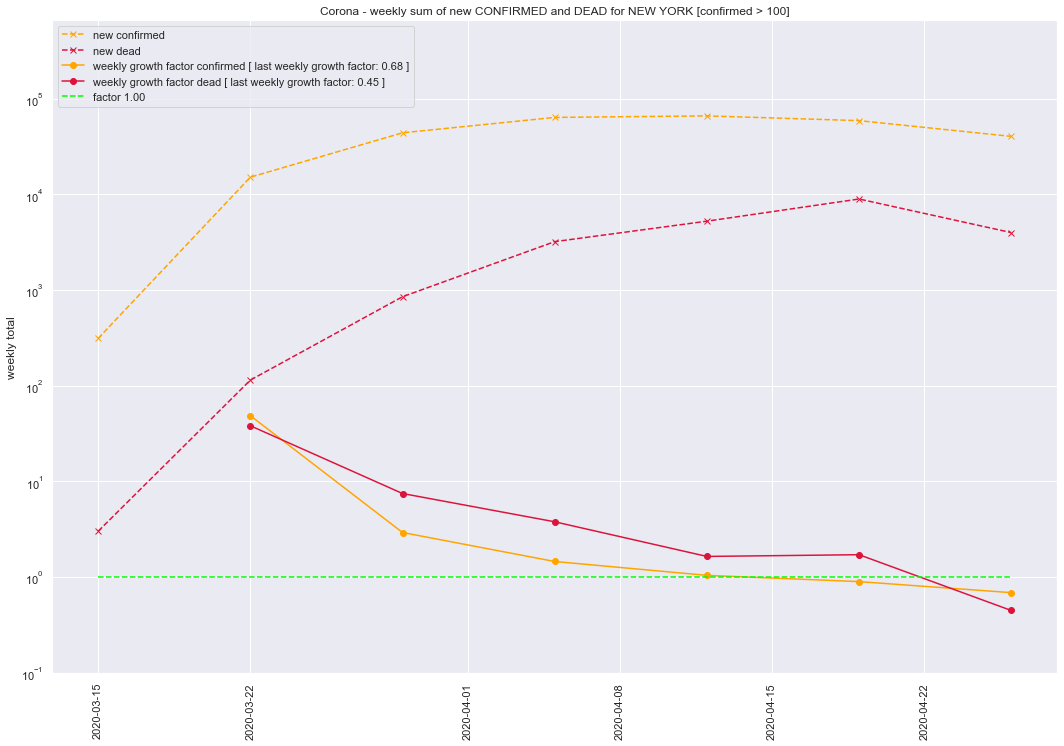

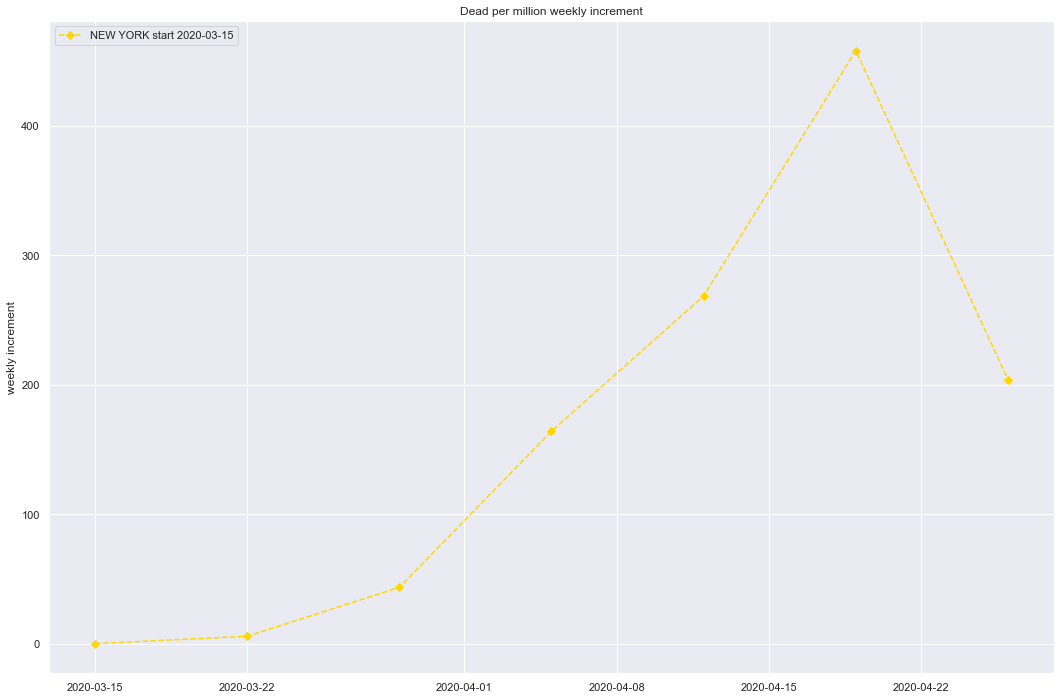

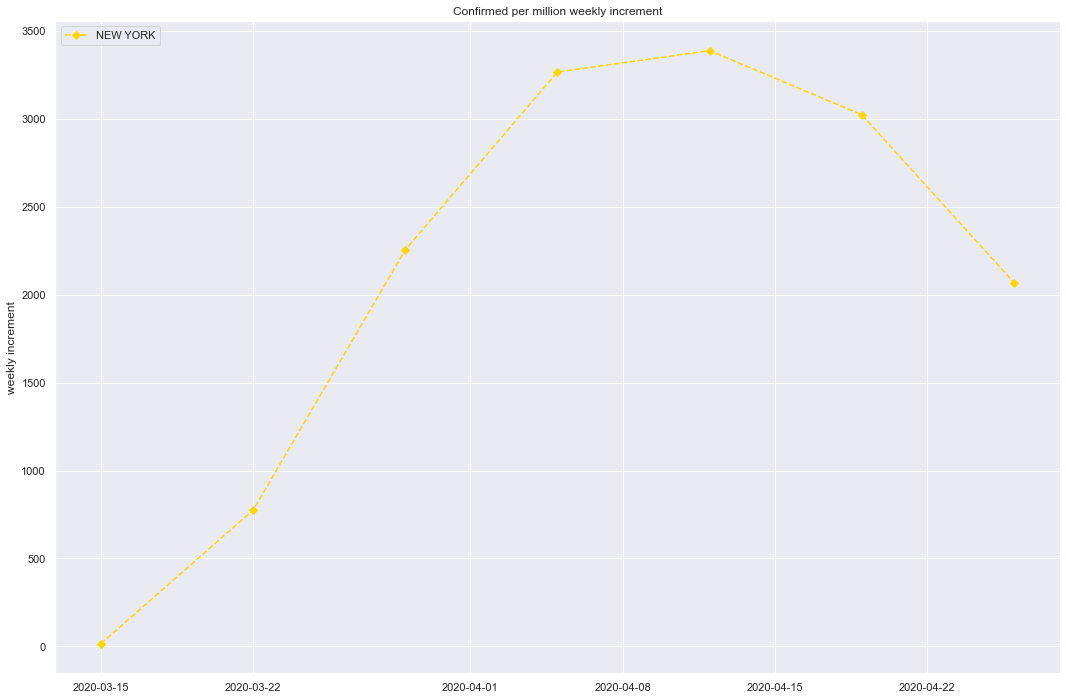

In [6]:
countries = ['Sweden','Spain','Italy','US','Germany','Netherlands']
colors = ['gold','b','r','g','k','c','lime']
#countries = ['Finland','Denmark','Norway','Austria','Belgium','France']
#countries = ['New York']

fignr = 1

for c in countries:
    weekly = process_country(c)
    print ('++++++++++++++++ {} ++++++++++++++'.format(str.upper(c)))
    print (c,weekly.tail(10))
    plot(weekly,c)
    fignr += 1
    


# plot all normalized on same plot

plt.figure(fignr + 1,figsize=(18,12))
plt.figure(fignr + 2,figsize=(18,12))

for i,c in enumerate(countries):
    plt.figure(fignr +1 )
    plt.title('Dead per million weekly increment')
    weekly = process_country(c)
    
    plt.plot(weekly.index,weekly['dead_inc_per_M'],'D--',
             color=colors[i],label=c.upper() + ' start ' + str(weekly.index[0].date()))
    
    #plt.yscale('log') # NOTICE that log scale makes the growth look much smaller...!!!
    
    plt.legend(loc='upper left')
    plt.ylabel('weekly increment')
    plt.figure(fignr + 2)
    plt.title('Confirmed per million weekly increment')
    plt.plot(weekly.index,weekly['inc_per_M'],'D--',color=colors[i],label=c.upper())
    plt.legend(loc='upper left')
    plt.ylabel('weekly increment')

plt.figure(fignr +1)
plt.savefig('weekly__dead_consolidated_sums_per_million.jpg')
plt.figure(fignr +2)
plt.savefig('weekly_conf_consolidated_sums_per_million.jpg')